<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Первый-взгляд-на-данные" data-toc-modified-id="Первый-взгляд-на-данные-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Первый взгляд на данные</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Изучение-и-проверка-данных" data-toc-modified-id="Изучение-и-проверка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Изучение и проверка данных</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Воронка-событий" data-toc-modified-id="Воронка-событий-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Воронка событий</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Результаты-экперимента" data-toc-modified-id="Результаты-экперимента-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Результаты экперимента</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Поведение пользователей мобильного приложения

Цели проекта: 
 - Изучение воронки продаж мобильного приложения по продаже продуктов питания.
 - Анализ результатов A/A/B-эксперимента. Для тестируемой группы во всем приложении поменяли шрифты.
 
Изучаемые данные:
- Логи с данными о поведении пользователей приложения.

##  Первый взгляд на данные 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7
import matplotlib.dates as md
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
%config InlineBackend.figure_format='retina'
from matplotlib import cycler
import operator
colors = cycler('color',
                ['#345995', '#FB4D3D', '#8C2D7E',
                 '#E40066', '#03CEA4', '#EAC435',
                 '#806045', '#04724D', '#00A8E8',
                 '#88BB44', '#FFFFFF', '#FFBBBB','#00FF00','#000000'])
plt.rc('axes',facecolor='#E6E6E6',  edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 0.999)})
pd.set_option('chained_assignment', None)
import datetime 
import math as mth
from scipy import stats as st

In [2]:
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
except:
    df = pd.read_csv('logs_exp.csv', sep = '\t')

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


 - EventName — название события;
 - DeviceIDHash — уникальный идентификатор пользователя;
 - EventTimestamp — время события;
 - ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Поменяем названия столбцов на более удобные.

In [5]:
df.columns = ['event_name', 'id', 'event_timestamp', 'group']

Проверим на дупликаты строк.

In [6]:
print('Дупликаты строк:',df.duplicated().sum())

Дупликаты строк: 413


Удалим дупликаты.

In [7]:
df.drop_duplicates(inplace = True)

Поменяем названия тестуремых групп.

In [8]:
df['group'] = df['group'].astype('str')
df['group'] = df['group'].replace(
    {'246':'A',
     '247':'AA',
     '248':'B'})

Проверим, не попали ли пользователи в несколько групп тестирования.

In [9]:
df.groupby('id')['group'].nunique().value_counts()

1    7551
Name: group, dtype: int64

Добавим столбцы с информацией о дате

In [10]:
df['event_datetime'] = pd.to_datetime(df['event_timestamp'],  unit='s')
df['event_date'] = df['event_datetime'].dt.date

Поправим индекс.

In [11]:
df.reset_index(drop = True, inplace = True)

Поменяем названия событий на более удобные.

In [12]:
df['event_name'].replace({
    "MainScreenAppear": "main",
    "PaymentScreenSuccessful": "payment",
    "OffersScreenAppear": "offers",
    "CartScreenAppear": "cart",
    "Tutorial": "tutorial",
    }, inplace=True)

###  Выводы

Представленные данные - таблица с данными о поведении пользователей мобильного приложения. Дупликаты были удалены, а типы данных приведены к корректным - в остальном проблем в данных обнаружено не было. Можно приступить к более глубокой проверке данных.

## Изучение и проверка данных

Посчитаем сколько всего событий в логе и сколько всего пользователей.
Так же найдем среднее количесвто событий на пользователя.

In [13]:
print('Всего событий в логе:',len(df))
print('Всего пользователей в логе:',df['id'].nunique())
print('Среднее количество событий на пользователя: {:.0f}'.format(len(df) / df['id'].nunique()),
      ', медиана:', int(df.groupby('id')['event_name'].count().median()),
      ', мода:',df.groupby('id')['event_name'].count().mode()[0])

Всего событий в логе: 243713
Всего пользователей в логе: 7551
Среднее количество событий на пользователя: 32 , медиана: 20 , мода: 5


Выведем минимальную и максимальную дату, посмотрим на распределение.

In [14]:
 print('min date:',df['event_datetime'].min(),'|', 'max date:',df['event_datetime'].max())

min date: 2019-07-25 04:43:36 | max date: 2019-08-07 21:15:17


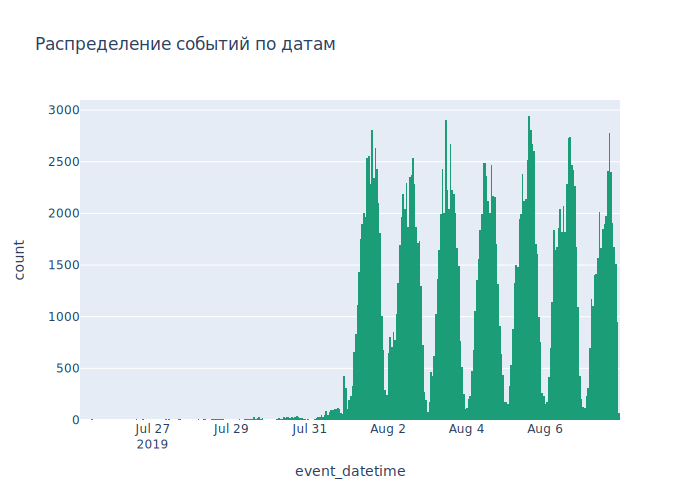

In [15]:
fig = px.histogram(df, x="event_datetime",
                   color_discrete_sequence=px.colors.qualitative.Dark2,
                   title = 'Распределение событий по датам')
fig.show('svg')


Похоже, данные не полные - в них попали часть событий из прошлого. Судя по приближенному графику распределения, на самом деле мы распологаем данными начиная с 31-07-2019 22:00:00 

Удалим данные ранее этой даты и посчитаем, сколько событий и пользователей мы потеряли.

In [16]:
print(
     'Удалено событий: {:.2%},'.format(
            1 -(len(df.query('event_datetime > "31-07-2019 22:00:00"')) / len(df))
                                   ),
            len(df) - len(df.query('event_datetime > "31-07-2019 22:00:00"'))
)


users_list = df.query('event_datetime > "31-07-2019 22:00:00"')['id'].unique()


print(
     'Удалено пользователей: {:.2%},'.format(
            df.query('id not in @users_list')['id'].nunique() / df['id'].nunique()
                                   ),
            df.query('id not in @users_list')['id'].nunique()
)

Удалено событий: 0.99%, 2413
Удалено пользователей: 0.17%, 13


In [17]:
df = df.query('event_datetime > "31-07-2019 22:00:00"')

Проверим, что у вас есть пользователи из всех трёх экспериментальных групп.

In [18]:
df['group'].unique()

array(['A', 'B', 'AA'], dtype=object)

### Выводы

Было обнаружено что данные не полные - в них попали часть событий из прошлого. На самом деле мы распологаем данными начиная с августа 2018 года. Ошибочные данные были удалены. 

## Воронка событий

Посмотрим, какие события есть в логах и как часто они встречаются. 

In [19]:
df['event_name'].value_counts()

main        117617
offers       46420
cart         42322
payment      33935
tutorial      1006
Name: event_name, dtype: int64

Посчитаем, сколько пользователей совершали каждое из этих событий и отсортируем события по числу пользователей. Так же посчитаем долю пользователей, которые хоть раз совершали событие.

In [20]:
event_count = df.groupby('event_name', as_index = False).agg({'id':'nunique'}).sort_values('id', ascending = False)
event_count.columns = ['event_name', 'users']
event_count['retension'] = round(event_count['users'] / df['id'].nunique(), 2)
event_count

,event_name,users,retension
1,main,7423,0.98
2,offers,4595,0.61
0,cart,3735,0.50
3,payment,3539,0.47
4,tutorial,841,0.11


Предпложительный порядок событий:
   1. Переход на главный экран (main)
   2. Экран выбора заказа (offers)
   3. Корзина (cart)
   4. Успешная оплата (payment)

На экран tutorial заходят далеко не все пользователи, включать это событие в изучаемую воронку не будем.

In [21]:
event_count = event_count.query('event_name != "tutorial"')

Выведем ворнку событий для найденной цепочки.

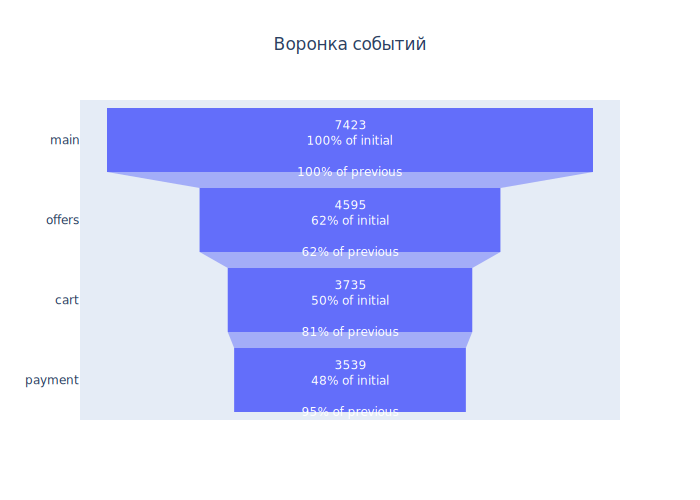

In [22]:
fig = go.Figure(go.Funnel(
    y = event_count['event_name'],
    x = event_count['users'],
    textinfo = "value+percent previous+percent initial"
))
fig.update_layout(title_text='Воронка событий', title_x=0.5)

fig.show('svg')

### Выводы

Обнаруженные порядок событий:
   1. Переход на главный экран (main)
   2. Экран выбора заказа (offers)
   3. Корзина (cart)
   4. Успешная оплата (payment)

Потери пользователей с предыдущего шага:
 - экран выбора заказа: 62%
 - экран корзины: 81%
 - успешная оплата: 95%

На главном экране теряется больше всего пользователей - до выбора заказа доходит только 62 процента пользователей.

От главного экрана до успешной оплаты доходит 48 процентов пользователей.

## Результаты экперимента

Посчитаем количество пользователей в каждой группе.

In [23]:
users_count = df.groupby('group')['id'].agg({'id':'nunique'}).reset_index()
users_count.columns = ['group', 'users']
users_count

,group,users
0,A,2484
1,AA,2517
2,B,2537


Соберем данные о конверсии по каждой группе в таблицу.

In [24]:
event_count_A = df.query('group == "A"').groupby('event_name')\
.agg({'id':'nunique','group':'max'}).sort_values('id', ascending = False).reset_index()

event_pivot_A = event_count_A.pivot_table(index = 'group', values = 'id', columns = 'event_name')\
.reset_index().rename_axis(None, axis=1).reset_index(drop=True)

event_pivot_A = event_pivot_A[['group','main','offers','cart',
       'payment','tutorial']]


event_count_AA = df.query('group == "AA"').groupby('event_name')\
.agg({'id':'nunique','group':'max'}).sort_values('id', ascending = False).reset_index()

event_pivot_AA = event_count_AA.pivot_table(index = 'group', values = 'id', columns = 'event_name')\
.reset_index().rename_axis(None, axis=1).reset_index(drop=True)

event_pivot_AA = event_pivot_AA[['group','main','offers','cart',
       'payment','tutorial']]


event_count_B = df.query('group == "B"').groupby('event_name')\
.agg({'id':'nunique','group':'max'}).sort_values('id', ascending = False).reset_index()

event_pivot_B = event_count_B.pivot_table(index = 'group', values = 'id', columns = 'event_name')\
.reset_index().rename_axis(None, axis=1).reset_index(drop=True)

event_pivot_B = event_pivot_B[['group','main','offers','cart',
       'payment','tutorial']]

event_pivot = pd.concat([event_pivot_A , event_pivot_AA, event_pivot_B], axis=0).reset_index(drop = True)
event_pivot = event_pivot.merge(users_count, on = 'group')
event_pivot = event_pivot.set_index('group')


Добавим информацию о сумме контрольных A и AA групп.

In [25]:
A_sum = event_pivot.loc['A':'AA']

A_sum.loc['A+AA',:]= A_sum.sum(axis=0).astype('int')
for column in A_sum.columns:
    A_sum[column] = A_sum[column].astype('int')

event_pivot = pd.concat([event_pivot , A_sum], axis=0).drop_duplicates()
event_pivot = event_pivot.drop('tutorial', axis = 1)
event_pivot

,main,offers,cart,payment,users
group,,,,,
A,2450,1542,1266,1200,2484
AA,2479,1522,1239,1158,2517
B,2494,1531,1230,1181,2537
A+AA,4929,3064,2505,2358,5001


Посчитаем долю пользователей на каждом этапе и выведем график. 

In [48]:
retension_data = event_pivot.copy()
retension_data['retension_main'] = round(retension_data['main'] / retension_data['users'], 3)
retension_data['retension_cart'] = round(retension_data['cart'] / retension_data['users'], 3) 
retension_data['retension_offers'] = round(retension_data['offers'] / retension_data['users'], 3) 
retension_data['retension_payment'] = round(retension_data['payment'] / retension_data['users'], 3) 

In [50]:
retension = retension_data[['retension_main', 'retension_offers','retension_cart','retension_payment']]
retension

,retension_main,retension_offers,retension_cart,retension_payment
group,,,,
A,0.986,0.621,0.510,0.483
AA,0.985,0.605,0.492,0.460
B,0.983,0.603,0.485,0.466
A+AA,0.986,0.613,0.501,0.472


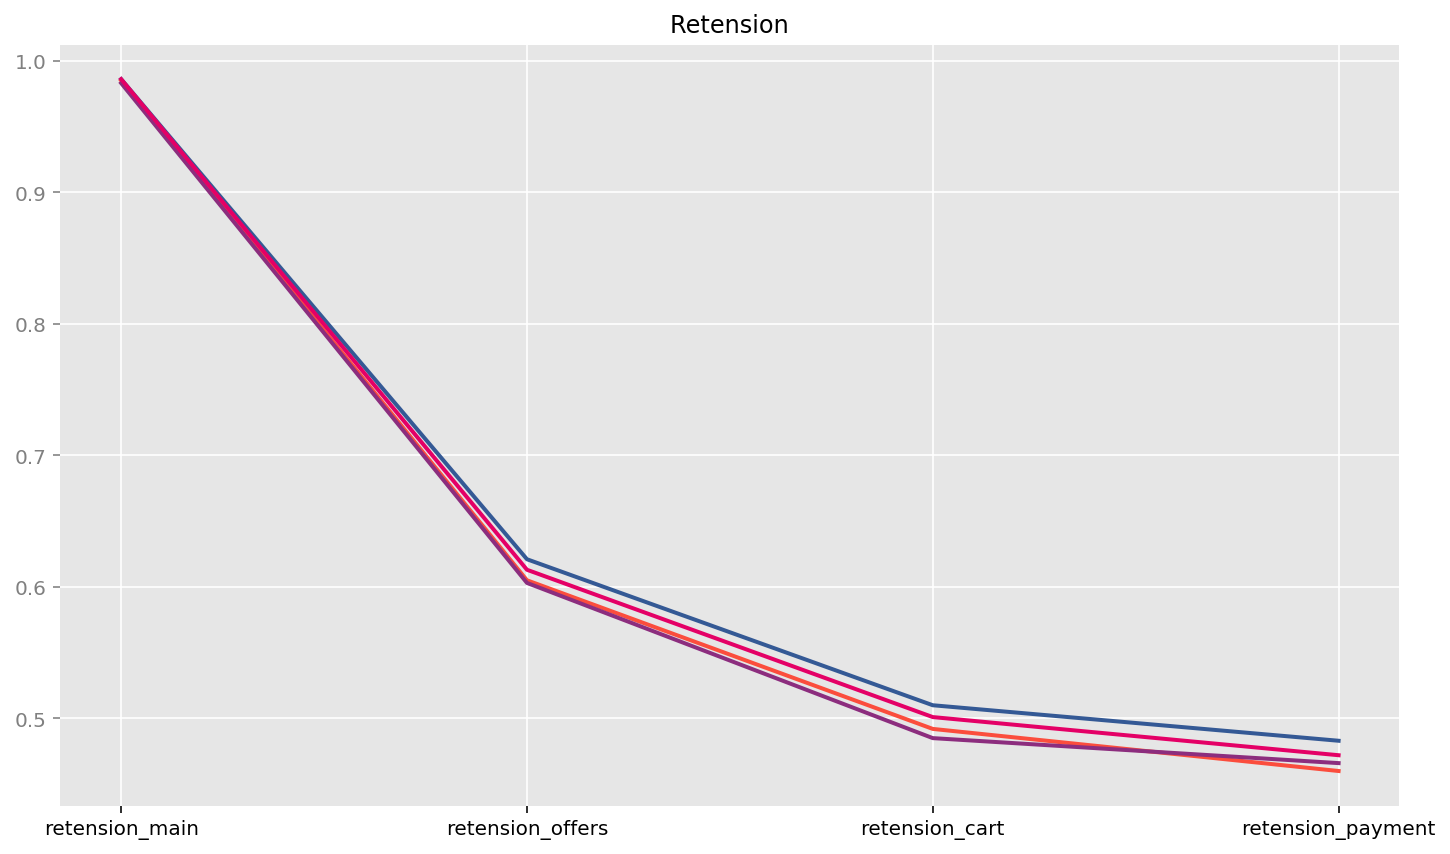

In [53]:

fig, ax = plt.subplots(figsize = (12, 7))
plt.plot(retension.T)
#retension.T.plot()
plt.title('Retension')

plt.show()

Проверим статистичекую значимость различий конвесий для каждого этапа:
  -  Между двумя контрольными группами(A - AA)
  -  Между первой контрольной группой и тестируемой (A - B)
  -  Между второй контрольной группой и тестируемой (AA - B)
  -  Между суммой контрольных групп и тестируемой (A+AA - B)
  
  
Для каждого проверки сформируем  нулевую и альтернативную гипотезу:
- Нулевая гипотеза - между долями пользователей, побывавших на этапах воронки, нет статистически значимых различий.
- Альтернативная гипотеза - различия есть.

Добавим функцию для Z теста.

In [ ]:
def z_test(data, group_1, group_2, success, trial, alpha):
    
    successes = [data.loc[group_1, success], data.loc[group_2, success]]
    trials = [data.loc[group_1, trial], data.loc[group_2, trial]]

    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2 
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )
    distr = st.norm(0, 1)
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
 
    print('p-значение: ', p_value)
 
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 
 

Применим поправку Бонферони к критическому уровню статистической значимости. Предстоит сделать 16 тестов.

Изначально выбранный критический уровень статистической значимости - 0.05

In [ ]:
bonferroni_alpha = 0.05 / 16
print('bonferroni_alpha:', bonferroni_alpha)

Проверим уровень статистической значимости конверсии для каждого шага двух контрольных групп (A и AA)

In [ ]:
for stage in event_pivot[['main', 'offers', 'cart', 'payment']].columns:
    print(),
    print(stage,'stage'),
    print(),
    z_test(event_pivot, 'A', 'AA', stage, 'users', bonferroni_alpha)
    
    

Разбиение на группы работает корректно, статистической разницы не обнаружено

Проверим разницу первой контрольной группы и группы теста (A и B)

In [ ]:
for stage in event_pivot[['main', 'offers', 'cart', 'payment']].columns:
    print(),
    print(stage,'stage'),
    print(),
    z_test(event_pivot, 'A', 'B', stage, 'users', bonferroni_alpha)

Статистически значимой разницы между первой контрольной группой и тестовой обнаружено не было.

Проверим разницу первой контрольной группы и группы теста (AA и B)

In [ ]:
for stage in event_pivot[['main', 'offers', 'cart', 'payment']].columns:
    print(),
    print(stage,'stage'),
    print(),
    z_test(event_pivot, 'AA', 'B', stage, 'users', bonferroni_alpha)

Статистически значимой разницы между второй контрольной группой и тестовой обнаружено не было.

Проверим разницу между обеими контрольнными группами и группой теста (AA+A и B)

In [ ]:
for stage in event_pivot[['main', 'offers', 'cart', 'payment']].columns:
    print(),
    print(stage,'stage'),
    print(),
    z_test(event_pivot, 'A+AA', 'B', stage, 'users', bonferroni_alpha)

Статистически значимой разницы между обеими контрольными группами и тестовой обнаружено не было.

## Выводы

В процессе исследования воронки событий пользователей были сделаны следующие выводы:

Обнаруженный порядок событий:
   1. Переход на главный экран 
   2. Экран выбора заказа 
   3. Корзина 
   4. Успешная оплата 

Потери пользователей с предыдущего шага:
 - экран выбора заказа: 62%
 - экран корзины: 81%
 - успешная оплата: 95%

На главном экране теряется больше всего пользователей - до выбора заказа доходит только 62 процента. Возможно пользователи просто не могут найти нужную страницу.  

Рекомендуется провести приоретизацию возможных гипотез - предположительно юзабилити интерфейса нуждается в более сильных изменениях, чем замена шрифтов.

От главного экрана до успешной оплаты доходит 48 процентов пользователей.

В процессе анализа A/A/B теста были сделаны следующие выводы:
   - Контрольные группы были разделены корректно - статистически значимых различий в конверсии между ними обнаружено не было. 
   - Различия в конверсии для каждого этапа событий между контрольными и тестовыми группами обнаружено не было. Рекомендуется закончить тестированиеи приступить к проверке следующих гипотез.
    
